In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [104]:
data_dir = "dataset/Water_Quality/"
data = pd.read_csv(data_dir + "water_potability.csv")
data = data.sample(frac=1, replace=True, random_state=1).reset_index(drop=True)
data = data.dropna()
label = data.columns[-1]
features = data.columns[:-1]
# Separate the data
X, y = data[features], data[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [105]:
y_train.value_counts()

0    792
1    530
Name: Potability, dtype: int64

In [106]:
y_test.value_counts()

0    425
1    227
Name: Potability, dtype: int64

In [107]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1322, 9) (1322,) (652, 9) (652,)


# Default Model

In [108]:
model_default = svm.SVC(kernel='sigmoid')
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.5068775008501626
Recall: 0.49693251533742333
F1 Score: 0.5014846993783942


(0.5068775008501626, 0.49693251533742333, 0.5014846993783942, None)

In [109]:
pd.DataFrame(y_pred_default).value_counts()

0    405
1    247
dtype: int64

# SMOTE Oversampling

In [110]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = svm.SVC(kernel='sigmoid')
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.5265251400770713
Recall: 0.49079754601226994
F1 Score: 0.502306797519691


(0.5265251400770713, 0.49079754601226994, 0.502306797519691, None)

In [111]:
print(X_train_sm.shape,y_train_sm.shape)

(1584, 9) (1584,)


# MAPS

In [112]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [113]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [114]:
def mispredict_label(row):
    if row['Potability'] == row['pred']:
        return False
    return True

In [115]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [116]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 9.691727638244629 BGMD Spent: 0.11893486976623535


([[0.646067415730337, 'Solids<=23565.17840440943'],
  [0.5476190476190477, 'Solids<=19155.727560817704'],
  [0.030030030030030033, 'Chloramines>11.1707886197812']],
 [[0.6540284360189572, 'Solids<=28780.340431632725'],
  [0.646067415730337, 'Solids<=23565.17840440943'],
  [0.5476190476190477, 'Solids<=19155.727560817704']])

In [117]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['Potability'])

In [118]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = svm.SVC(kernel='sigmoid')
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 1322)])
Performance on all data
Precision: 0.5068775008501626
Recall: 0.49693251533742333
F1 Score: 0.5014846993783942
Upweight_value:  2
dict_items([(2, 1066), (1, 256)])
Performance on all data
Precision: 0.5290905508505203
Recall: 0.5383435582822086
F1 Score: 0.5333082832026418
Upweight_value:  3
dict_items([(3, 1066), (1, 256)])
Performance on all data
Precision: 0.5290905508505203
Recall: 0.5383435582822086
F1 Score: 0.5333082832026418
Upweight_value:  4
dict_items([(4, 1066), (1, 256)])
Performance on all data
Precision: 0.5291516321924038
Recall: 0.5398773006134969
F1 Score: 0.5339655134675396
Upweight_value:  5
dict_items([(5, 1066), (1, 256)])
Performance on all data
Precision: 0.5301601858706225
Recall: 0.5398773006134969
F1 Score: 0.5345641617572939
Upweight_value:  6
dict_items([(6, 1066), (1, 256)])
Performance on all data
Precision: 0.5292094393488429
Recall: 0.5414110429447853
F1 Score: 0.5346001646615144
Upweight_value:  7
dict_items([

Performance on all data
Precision: 0.5260754401076743
Recall: 0.5398773006134969
F1 Score: 0.5320927057657374
Upweight_value:  52
dict_items([(52, 1066), (1, 256)])
Performance on all data
Precision: 0.5260754401076743
Recall: 0.5398773006134969
F1 Score: 0.5320927057657374
Upweight_value:  53
dict_items([(53, 1066), (1, 256)])
Performance on all data
Precision: 0.5260754401076743
Recall: 0.5398773006134969
F1 Score: 0.5320927057657374
Upweight_value:  54
dict_items([(54, 1066), (1, 256)])
Performance on all data
Precision: 0.5260754401076743
Recall: 0.5398773006134969
F1 Score: 0.5320927057657374
Upweight_value:  55
dict_items([(55, 1066), (1, 256)])
Performance on all data
Precision: 0.5260754401076743
Recall: 0.5398773006134969
F1 Score: 0.5320927057657374
Upweight_value:  56
dict_items([(56, 1066), (1, 256)])
Performance on all data
Precision: 0.5260754401076743
Recall: 0.5398773006134969
F1 Score: 0.5320927057657374
Upweight_value:  57
dict_items([(57, 1066), (1, 256)])
Performanc

Best weight on all is:  7
Best weight on misprediction area is:  7


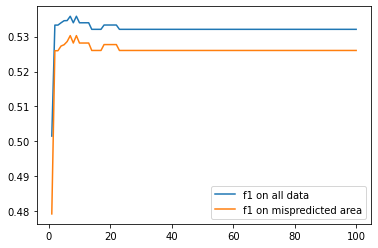

In [119]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [120]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = svm.SVC(kernel='sigmoid')
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='Potability')

Performance on all data
Precision: 0.5302871262557345
Recall: 0.5429447852760736
F1 Score: 0.5358450499387497
y_actual_MD: 516
y_predict_default_MD: 516
y_pred_SMOTE_MD: 516
y_pred_MAPS_MD: 516

Default: (0.5105029700225652, 0.46511627906976744, 0.4791792618343383, None)
SMOTE: (0.5358660006190595, 0.4573643410852713, 0.4673313359531823, None)
MAPS: (0.5397532455845543, 0.5232558139534884, 0.5302913161801088, None)


In [121]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Water_Quality.csv')

# Just Train Twice

In [122]:
from helper import generate_JTT_Weights

In [123]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = svm.SVC(kernel='sigmoid')
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.5449406397402263
Recall: 0.5308924485125859
F1 Score: 0.5362489260760184


(0.5449406397402263, 0.5308924485125859, 0.5362489260760184, None)

In [124]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = svm.SVC(kernel='sigmoid')
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.5707071264349368
Recall: 0.5475460122699386
F1 Score: 0.5559526778940784
Performance on all data
Precision: 0.5707071264349368
Recall: 0.5475460122699386
F1 Score: 0.5559526778940784
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performance on all data
Precision: 0.5696657432997536
Recall: 0.5460122699386503
F1 Score: 0.5545481225311636
Performanc

JTT Best weight on all is:  10
JTT Best f1 score on all:  0.5559526778940784


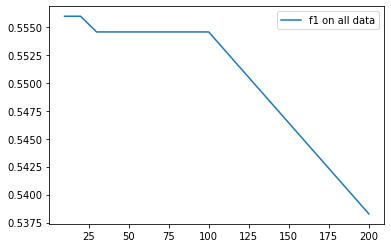

In [125]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [126]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = svm.SVC(kernel='sigmoid')
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='Potability')

Performance on all data
Precision: 0.5707071264349368
Recall: 0.5475460122699386
F1 Score: 0.5559526778940784
y_actual_MD: 516
y_predict_default_MD: 516
y_pred_SMOTE_MD: 516
y_pred_MAPS_MD: 516

Default: (0.5718635800209374, 0.5910852713178295, 0.579237559935968, None)
SMOTE: (0.5358660006190595, 0.4573643410852713, 0.4673313359531823, None)
MAPS: (0.5397532455845543, 0.5232558139534884, 0.5302913161801088, None)
